In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

### 导入数据，并了解数据基本信息和结构

In [3]:
titanic_data = pd.read_csv("titanic/train.csv")

In [4]:
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
titanic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
titanic_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [14]:
# 查看缺失值信息
titanic_data.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

### 处理缺失值

In [8]:
# 删除Cabin列
titanic_data = titanic_data.drop(columns='Cabin', axis=1)

In [10]:
# 将Age的均值，填充至缺失值处（直接在原始数据上进行填充操作）
titanic_data['Age'].fillna(titanic_data['Age'].mean(), inplace=True)

In [12]:
# 找到Embarked众数的索引
titanic_data['Embarked'].mode()

0    S
Name: Embarked, dtype: object

In [13]:
# 确认只有一个众数，直接填充Embarked列
titanic_data['Embarked'].fillna(titanic_data['Embarked'].mode()[0], inplace=True)

In [15]:
# 检查缺失值信息
titanic_data.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

### 初步数据分析，查看相关性

In [17]:
# 统计幸存者数量
titanic_data['Survived'].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

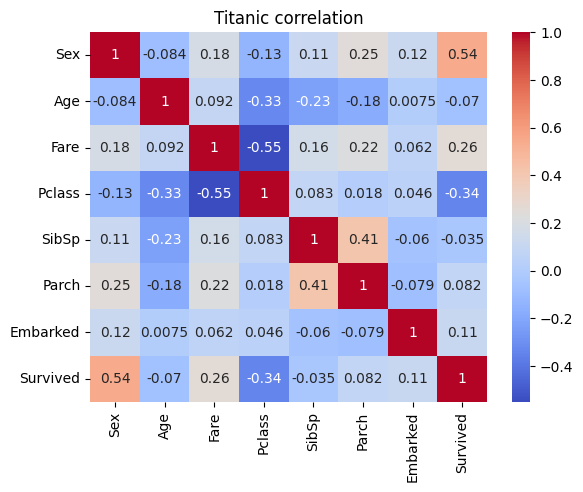

In [28]:
# 进行相关性分析
titanic_data.replace({'Sex':{'male': 0, 'female': 1}, 'Embarked':{'S':0, 'C':1, 'Q':2}}, inplace=True)

numeric_features = ['Sex', 'Age', 'Fare', 'Pclass', 'SibSp', 'Parch', 'Embarked', 'Survived']
numeric_data = titanic_data[numeric_features]
corr_matrix = numeric_data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Titanic correlation')
plt.show()

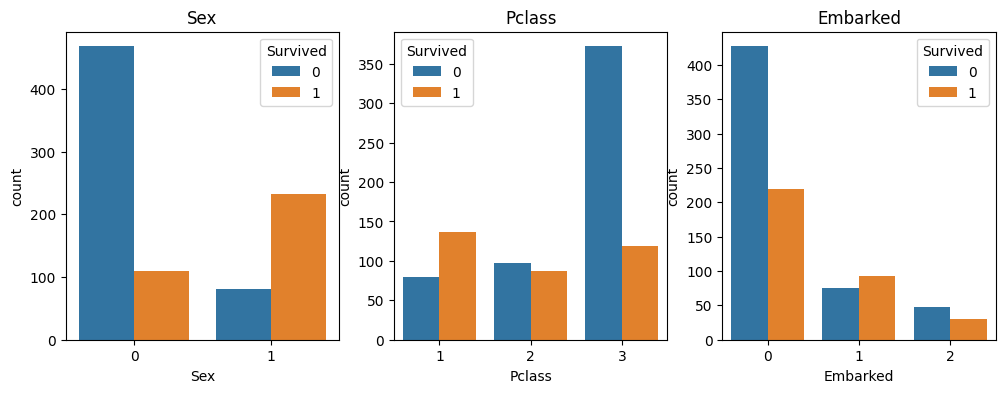

In [32]:
# 查看相关系数较高的三个特征
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# 绘制 countplot
sns.countplot(x='Sex', hue='Survived', data=titanic_data, ax=axes[0])
sns.countplot(x='Pclass', hue='Survived', data=titanic_data, ax=axes[1])
sns.countplot(x='Embarked', hue='Survived', data=titanic_data, ax=axes[2])

# 设置标题
axes[0].set_title('Sex')
axes[1].set_title('Pclass')
axes[2].set_title('Embarked')

plt.show()

### train-test 划分数据集

In [33]:
# 对相关性高的特征进行限制，使其在不同的数据集分布规律相似
# StratifiedShuffleSplit数据集拆分方法，在保持样本类别分布相同的情况下随机分割数据集
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
for train_indices, test_indices in split.split(titanic_data, titanic_data[['Survived', 'Pclass', 'Sex']]):
    strat_train_set = titanic_data.loc[train_indices]
    strat_test_set = titanic_data.loc[test_indices]

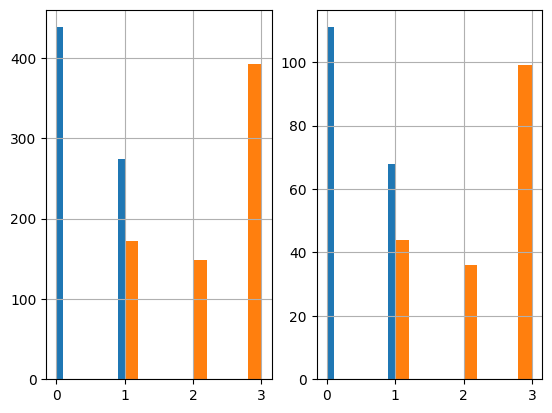

In [34]:
# 检验两个数据集的特征分布是否相似
plt.subplot(1,2,1)
strat_train_set['Survived'].hist()
strat_train_set['Pclass'].hist()

plt.subplot(1,2,2)
strat_test_set['Survived'].hist()
strat_test_set['Pclass'].hist()

plt.show()

In [37]:
X_train = strat_train_set.drop(columns = ['PassengerId', 'Name', 'Ticket', 'Survived'], axis=1)
Y_train = strat_train_set['Survived']

X_test = strat_test_set.drop(columns = ['PassengerId', 'Name', 'Ticket', 'Survived'], axis=1)
Y_test = strat_test_set['Survived']

In [57]:
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
607,1,0,27.0,0,0,30.5000,0
131,3,0,20.0,0,0,7.0500,0
246,3,1,25.0,0,0,7.7750,0
572,1,0,36.0,0,0,26.3875,0
805,3,0,31.0,0,0,7.7750,0


### 训练模型

In [39]:
# 线性回归模型
model = LogisticRegression()

model.fit(X_train, Y_train)

LogisticRegression()

### 对模型进行评分，检测

In [43]:
X_train_prediction = model.predict(X_train)
traning_data_accuracy = accuracy_score(Y_train, X_train_prediction)
print("Accuracy score of training data: ", traning_data_accuracy)

Accuracy score of training data:  0.7991573033707865


In [44]:
test_data_accuracy = accuracy_score(Y_test, model.predict(X_test))
print("Accuracy score of test data: ", test_data_accuracy)

Accuracy score of test data:  0.8044692737430168


### 加载测试模型，进行最终测试

In [45]:
titanic_test_data = pd.read_csv("titanic/test.csv")

In [46]:
titanic_test_data

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [47]:
titanic_test_data.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [53]:
titanic_test_data['Age'].fillna(titanic_test_data['Age'].mean(), inplace=True)
titanic_test_data['Embarked'].fillna(titanic_test_data['Embarked'].mode()[0], inplace=True)
titanic_test_data.fillna(titanic_test_data['Fare'].mean(), inplace=True)
titanic_test_data.isnull().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

In [55]:
titanic_test_data.replace({'Sex':{'male': 0, 'female': 1}, 'Embarked':{'S':0, 'C':1, 'Q':2}}, inplace=True)

In [56]:
titanic_test_data

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,892,3,"Kelly, Mr. James",0,34.50000,0,0,330911,7.8292,2
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",1,47.00000,1,0,363272,7.0000,0
2,894,2,"Myles, Mr. Thomas Francis",0,62.00000,0,0,240276,9.6875,2
3,895,3,"Wirz, Mr. Albert",0,27.00000,0,0,315154,8.6625,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,22.00000,1,1,3101298,12.2875,0
...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",0,30.27259,0,0,A.5. 3236,8.0500,0
414,1306,1,"Oliva y Ocana, Dona. Fermina",1,39.00000,0,0,PC 17758,108.9000,1
415,1307,3,"Saether, Mr. Simon Sivertsen",0,38.50000,0,0,SOTON/O.Q. 3101262,7.2500,0
416,1308,3,"Ware, Mr. Frederick",0,30.27259,0,0,359309,8.0500,0


In [58]:
final_test = titanic_test_data.drop(columns = ['PassengerId', 'Name', 'Ticket'], axis=1)
final_test

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,0,34.50000,0,0,7.8292,2
1,3,1,47.00000,1,0,7.0000,0
2,2,0,62.00000,0,0,9.6875,2
3,3,0,27.00000,0,0,8.6625,0
4,3,1,22.00000,1,1,12.2875,0
...,...,...,...,...,...,...,...
413,3,0,30.27259,0,0,8.0500,0
414,1,1,39.00000,0,0,108.9000,1
415,3,0,38.50000,0,0,7.2500,0
416,3,0,30.27259,0,0,8.0500,0


In [59]:
predictions = model.predict(final_test)
final_df = pd.DataFrame(titanic_test_data['PassengerId'])
final_df['Survived'] = predictions
final_df.to_csv("titanic/predictions.csv", index=False)